1. volatility analysis
2. trailing stop back testing


In [ ]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
# stock = ['MRVL', 'MSI', 'NOK', 'LRCX', 'SWIR', 'LITE', 'CCI', 'CCOI']
stock = ['TRI', 'FDS', 'SPGI']
df_hl = pd.DataFrame()
for i in tqdm(stock):
    df = web.DataReader(i, data_source='yahoo', start='01-01-2020')
    df_hl[i + '-high'] = df['High']
    df_hl[i + '-low'] = df['Low']
    

In [ ]:
def daily_vol_rank(stocklist, dataframe_hl=pd.DataFrame(), remove_xtrem_days=2, startdate='01-01-2020'):
    '''
    dataframe_hl = panda datareader from yahoo finance for OHLC data
    remove_xtrem_days = to exclude certain xtrem external one-off events caused large volatility
    '''
    result = {}

    if dataframe_hl.empty:
        df_temp=pd.DataFrame()
        for i in stocklist:    
            df_temp = web.DataReader(i, data_source='yahoo', start=startdate)
            dataframe_hl[i + '-high'] = df_temp['High']
            dataframe_hl[i + '-low'] = df_temp['Low']

    ''' compare stocks' daily volatility by calculating std of (high-low).std and remove extreme volatile days  '''
    for i in stocklist:        
        l = (dataframe_hl[i + '-high'] - dataframe_hl[i + '-low'])/dataframe_hl[i + '-high']
        result[i]=np.std(sorted(l)[:-remove_xtrem_days])
    return result

In [ ]:
stock_daily_vol_rank_dict = daily_vol_rank(stock, df_hl, remove_xtrem_days=3).items()
{k: v for k, v in sorted(stock_daily_vol_rank_dict, key=lambda item: item[1], reverse=True)}
# print(stock_daily_vol_rank_dict)

In [ ]:
l = (df_hl['FDS-high'] - df_hl['FDS-low'])/df_hl['FDS-high']
l[l>0.045].count()
#l.median()
l

In [ ]:
plt.style.use('seaborn-whitegrid')
l.plot()
plt.show

In [ ]:
def multi_days_vol_rank(stocklist, dataframe_hl=pd.DataFrame(), remove_xtrem_days=2, hldays=2, startdate='01-01-2020'):
    '''
    dataframe_hl = panda datareader from yahoo finance for OHLC data
    remove_xtrem_days = to exclude certain xtrem external one-off events caused large volatility
    hldays = defines high-low resolution, eg default hldays = 2, highest and lowest price of every 2 days
    '''
    result = {}
    nh = []; nl = []
    if dataframe_hl.empty:
        df_temp=pd.DataFrame()
        for i in stocklist:    
            df_temp = web.DataReader(i, data_source='yahoo', start=startdate)
            dataframe_hl[i + '-high'] = df_temp['High']
            dataframe_hl[i + '-low'] = df_temp['Low']

    ''' compare 2020 stocks' volatility by calculating std of (high-low) across hldays and remove extreme volatile days
    hldays is the high low resolution in days  '''
    
    for i in stocklist:
        for j in range(0, len(dataframe_hl[i + '-high']), hldays):
            nh.append(np.nanmax(dataframe_hl[i + '-high'][j:j+hldays]))
            nl.append(np.nanmin(dataframe_hl[i + '-low'][j:j+hldays]))

        l = np.divide(np.subtract(nh,nl),nh)
        result[i]=np.std(sorted(l)[:-remove_xtrem_days])
        nh = []; nl = []
    return result


In [ ]:
m_days_vol_rank = multi_days_vol_rank(stock, df_hl, hldays=3).items()
{k: v for k, v in sorted(m_days_vol_rank, key=lambda item: item[1], reverse=True)}
#print(m_days_vol_rank)

In [ ]:
print(multi_days_vol_rank(stock, hldays=3))

In [ ]:
# volatity = high - low / high
nh = []; nl = []

for j in range(0, len(df_hl['NOK-high']), 3):
    nh.append(np.nanmax(df_hl['NOK-high'][j:j+3]))
    nl.append(np.nanmin(df_hl['NOK-high'][j:j+3]))
l = np.divide(np.subtract(nh, nl), nh)
m = sorted(l)
print(m)
print(np.std(m[2:-2]))


In [ ]:
abc = [1,2,3]
bcd = [4,5,6]
np.subtract(abc, bcd)

In [ ]:
df_hl.loc['20200501']['MRVL-high']

In [ ]:
transactionDate = df_hl.index
transactionDate[10]

In [ ]:
Entry = []; Exit = []
flag = 1 #  1 for buy, -1 for sell
df_hl.loc['20200501':'20200506'][['MSI-low', 'MSI-high']]

for i in df_hl.index:
    print(df_hl.loc[i]['MSI-low'])


In [ ]:
# 5% trailing-stop
buy_signal = [np.nan]; sell_signal = [np.nan]
flag = 1 #  1 for buy, -1 for sell
ceiling = 0 
bottom = df_hl['FDS-low'][0]
transactionDate = df_hl.index

for i in range(len(df_hl['FDS-high'])-1):
    if flag == 1:
        bottom = min(bottom, df_hl['FDS-low'][i+1])
        sell_signal.append(np.nan)
        # print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.1)
        if df_hl['FDS-low'][i+1] <= bottom*1.05 < df_hl['FDS-high'][i+1]: # limit order hit the next day
            buy_signal.append(bottom*1.05)
            print(transactionDate[i+1], " buy @ ", bottom*1.05)
            flag = -1
            ceiling = df_hl['FDS-high'][i+1]
        else:
            buy_signal.append(np.nan)
            
    elif flag == -1:
        ceiling = max(ceiling, df_hl['FDS-high'][i+1])
        buy_signal.append(np.nan)
        # print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.1)
        if df_hl['FDS-low'][i+1] <= ceiling/1.05 < df_hl['FDS-high'][i+1]: # stop loss order now hit next day
            sell_signal.append(ceiling/1.05)
            print(transactionDate[i+1], "sell @ ", ceiling/1.05)
            flag = 1
            bottom = df_hl['FDS-low'][i+1]
        else:
            sell_signal.append(np.nan)


In [ ]:
signals = pd.DataFrame()
signals['Buy'] = buy_signal
signals['Sell'] = sell_signal
i = df_hl.index
signals['date'] = i
signals = signals.set_index('date')

In [ ]:
def trailing_stop_signals(df_hl, trailing_pc):
    '''input high low dataframe and trailing percentage eg for 2%, trailing_pc=2)'''
    tpc = trailing_pc/100 + 1
    buy_signal = [np.nan]; sell_signal = [np.nan]
    flag = 1 #  1 for buy, -1 for sell
    ceiling = 0 
    bottom = df_hl['low'][0]
    transactionDate = df_hl.index

    for i in range(len(df_hl['high'])-1):
        if flag == 1:
            bottom = min(bottom, df_hl['low'][i+1])
            sell_signal.append(np.nan)
            #print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.1)
            if df_hl['low'][i+1] <= bottom*tpc < df_hl['high'][i+1]: # limit order hit the next day
                buy_signal.append(bottom*tpc)
                print(transactionDate[i+1], " buy @ ", bottom*tpc)
                flag = -1
                ceiling = df_hl['high'][i+1]
            else:
                buy_signal.append(np.nan)
                
        elif flag == -1:
            ceiling = max(ceiling, df_hl['high'][i+1])
            buy_signal.append(np.nan)
            #print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.1)
            if df_hl['low'][i+1] <= ceiling/tpc < df_hl['high'][i+1]: # stop loss order now hit next day
                sell_signal.append(ceiling/tpc)
                print(transactionDate[i+1], "sell @ ", ceiling/tpc)
                flag = 1
                bottom = df_hl['low'][i+1]
            else:
                sell_signal.append(np.nan)

                
    df_hl['Buy'] = buy_signal
    df_hl['Sell'] = sell_signal
    
    return df_hl

In [ ]:
df = web.DataReader('FDS', data_source='yahoo', start='01-01-2020')
df_hl=pd.DataFrame()
df_hl['high'] = df['High']
df_hl['low'] = df['Low']
df_hl=trailing_stop_signals(df_hl, trailing_pc=5)

Back test Profit and Loss

In [ ]:
# always 100 shares
(df_hl['Sell'].sum()- df_hl['Buy'].sum())*100

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24.2,9))
plt.plot(df_hl['high'], label = 'High', alpha = 0.5)
plt.plot(df_hl['low'], label = 'Low', alpha = 0.5)
plt.scatter(df_hl.index, df_hl['Buy'], color = 'green', label = 'entry point', marker = '^', alpha = 1)
plt.scatter(df_hl.index, df_hl['Sell'], color = 'red', label = 'exit point', marker = 'v', alpha = 1)
plt.title('FDS HL Price with entry, exit point')
plt.xlabel('Date')
plt.ylabel('Prices in USD ($)')
plt.legend(loc='upper left')
plt.show()

In [ ]:

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['high'],
                    mode='lines',
                    name='Highs'))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['low'],
                    mode='lines',
                    name='Lows'))

fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['Buy'],
                    mode='markers',
                    name='buy',
                    text=df_hl['Buy']))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['Sell'],
                    mode='markers',
                    name='sell',
                    text=df_hl['Sell']))

fig.show()

<h1>Trailing stop v2</h1>

In [ ]:
buy_signal = [np.nan]; sell_signal = [np.nan]
sellline=[np.nan]; buyline = [] #
flag = 1 #  1 for buy, -1 for sell
ceiling = 0 
bottom = df_hl['FDS-low'][0]
buyline.append(bottom) #
transactionDate = df_hl.index

for i in range(len(df_hl['FDS-high'])-1):
    if flag == 1:
        bottom = min(bottom, df_hl['FDS-low'][i+1])
        sell_signal.append(np.nan)
        buyline.append(bottom*1.05) #
        sellline.append(np.nan) #
        print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom*1.05)
        if df_hl['FDS-low'][i+1] <= bottom*1.05 < df_hl['FDS-high'][i+1]: # limit order hit the next day
            buy_signal.append(bottom*1.05)
            print(transactionDate[i+1], " buy @ ", bottom*1.05)
            flag = -1
            ceiling = df_hl['FDS-high'][i+1]
        else:
            buy_signal.append(np.nan)
            if df_hl['FDS-low'][i+1] > bottom*1.05:
              print("Buy price < today's min price by:", (df_hl['FDS-low'][i+1] - bottom*1.05) / bottom*1.05 * 100, "%" )
            elif bottom*1.05 >= df_hl['FDS-high'][i+1]:
              print("Buy price > today's max price by:", (bottom*1.05 - df_hl['FDS-high'][i+1]) / bottom*1.05 * 100, "%" )

            
    elif flag == -1:
        ceiling = max(ceiling, df_hl['FDS-high'][i+1])
        buy_signal.append(np.nan)
        buyline.append(np.nan) #
        sellline.append(ceiling/1.05) #
        print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/1.05)
        if df_hl['FDS-low'][i+1] <= ceiling/1.05 < df_hl['FDS-high'][i+1]: # stop loss order now hit next day
            sell_signal.append(ceiling/1.05)
            print(transactionDate[i+1], "sell @ ", ceiling/1.05)
            flag = 1
            bottom = df_hl['FDS-low'][i+1]
        else:
            sell_signal.append(np.nan)
            if df_hl['FDS-low'][i+1] > ceiling/1.05:
              print("Sell price < today's min price by:", (df_hl['FDS-low'][i+1] - ceiling/1.05) / ceiling/1.05 * 100, "%" )
            elif ceiling/1.05 > df_hl['FDS-high'][i+1]:
              print("Sell price > today's max price by:", (ceiling/1.05 - df_hl['FDS-high'][i+1]) / ceiling/1.05 * 100, "%" )

In [ ]:
df_hl['FDS_Buy'] = buy_signal
df_hl['FDS_Sell'] = sell_signal
df_hl['FDS_buyline'] = buyline
df_hl['FDS_sellline'] = sellline

df_hl

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS-high'],
                    mode='lines',
                    line=dict(color='blue', width=0.8),
                    opacity=0.5,
                    name='Highs'))
fig.show()


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS-high'],
                    mode='lines',
                    line=dict(color='blue', width=0.8),
                    opacity=0.5,
                    name='Highs'))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS-low'],
                    mode='lines',
                    line=dict(color='red', width=0.8),
                    opacity=0.5,
                    name='Lows'))

fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_Buy'],
                    mode='markers',
                    name='buy',
                    text=df_hl['FDS_Buy']))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_Sell'],
                    mode='markers',
                    name='sell',
                    text=df_hl['FDS_Sell']))

fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_buyline'],
                    mode='lines',
                    #line=dict(color='blue', width=0.8),
                    #opacity=0.5,
                    name='Highs'))
fig.add_trace(go.Scatter(x=df_hl.index, y=df_hl['FDS_sellline'],
                    mode='lines',
                    #line=dict(color='red', width=0.8),
                    #opacity=0.5,
                    name='Lows'))


fig.show()

<h1> Trailing-stop with bollinger band assistance</h1>

In [1]:
import warnings
import numpy as np
import pandas as pd
# from tqdm import tqdm
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

df = web.DataReader("FDS", data_source='yahoo', start='01-01-2020')


In [2]:
# Calculate SMA, Standard Deviation σ
sma_period = 25
typical_price = (df['High'] + df['Low'] + df['Adj Close'])/3
df['SMA'] = df['Adj Close'].rolling(window=sma_period).mean()
df['2xSTD'] = df['Adj Close'].rolling(window=sma_period).std() * 1.8
df['Tp_SMA'] = typical_price.rolling(window=sma_period).mean()
df['2xTPSTD'] = df['Adj Close'].rolling(window=sma_period).std() * 1.8
df['Upper']= df['Tp_SMA'] + df['2xTPSTD'] 
df['Lower']= df['Tp_SMA'] - df['2xTPSTD'] 

In [3]:
def get_b_band_points(bband, period):
    bband_entry = []; bband_exit=[]

    for i in range(len(bband['Close'])):
        if bband['Close'][i] > bband['Upper'][i]: # close > upper band, sell
            bband_entry.append(np.nan)
            bband_exit.append(bband['Close'][i])
        elif bband['Close'][i] < bband['Lower'][i]: # close < lower band, buy
            bband_exit.append(np.nan)
            bband_entry.append(bband['Close'][i])
        else:
            bband_exit.append(np.nan)
            bband_entry.append(np.nan)
    return (bband_entry[period:], bband_exit[period:])

In [4]:
# df_temp=pd.DataFrame()
df_temp=get_b_band_points(df, sma_period)[0]
for i in range(sma_period):
    df_temp.insert(0,np.nan)

df['b_buy']=df_temp

df_temp=get_b_band_points(df, sma_period)[1]
for i in range(sma_period):
    df_temp.insert(0,np.nan)

df['b_sell']=df_temp

In [11]:
buy_signal = [np.nan]; sell_signal = [np.nan]
#sellline=[np.nan]; buyline = []
flag = 1 #  1 for buy, -1 for sell
ceiling = 0 
bottom = df['Low'][0]
#buyline.append(bottom)
transactionDate = df.index
bottom_up_ratio = 1.03
ceiling_down_ratio = 1.03


for i in range(len(df['High'])-1):
    if flag == 1:
        bottom = min(bottom, df['Low'][i+1])
        sell_signal.append(np.nan)
        #buyline.append(bottom*1.03)
        #sellline.append(np.nan)
        print(transactionDate[i+1], " bottom = ", bottom, " entry level = ", bottom * bottom_up_ratio)
        if df['Low'][i+1] <= bottom*bottom_up_ratio < df['High'][i+1]: # limit order hit the next day
            buy_signal.append(bottom*bottom_up_ratio)
            print(transactionDate[i+1], "buy @ ", bottom*bottom_up_ratio)
            flag = -1
            ceiling = df['High'][i+1]
            ceiling_down_ratio = 1.03
        elif ~np.isnan(df['b_buy'][i]):
            print("price drops: bottom now = ", df['b_buy'][i], "buyline 4%")
            bottom = df['b_buy'][i]
            bottom_up_ratio = 1.04 # buy when the drop stops
            buy_signal.append(np.nan)
        elif ~np.isnan(df['b_sell'][i]):
            print("price rises: bottom now = ", df['b_sell'][i], "buyline 2%")
            bottom = df['b_sell'][i]
            bottom_up_ratio = 1.02 # buy more agressively
            buy_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)

            
            


    elif flag == -1:
        ceiling = max(ceiling, df['High'][i+1])
        buy_signal.append(np.nan)
        #buyline.append(np.nan)
        #sellline.append(ceiling/1.03)
        print(transactionDate[i+1], " cieling = ",ceiling, " stop loss = ", ceiling/ceiling_down_ratio)
        if df['Low'][i+1] <= ceiling/1.03 < df['High'][i+1]: # stop loss order now hit next day
            sell_signal.append(ceiling/1.03)
            print(transactionDate[i+1], "sell @ ", ceiling/1.03)
            flag = 1
            bottom = df['Low'][i+1]
            bottom_up_ratio = 1.03
        elif ~np.isnan(df['b_buy'][i]):
            print("price drops: ceiling now = ", df['b_buy'][i], )
            ceiling = df['b_buy'][i]
            ceiling_down_ratio = 1.02
            sell_signal.append(np.nan)
        elif ~np.isnan(df['b_sell'][i]):
            print("price rises: ceiling now = ", df['b_sell'][i])
            ceiling = df['b_sell'][i]
            ceiling_down_ratio = 1.04
            sell_signal.append(np.nan)
        else:
            sell_signal.append(np.nan)

2020-01-03 00:00:00  bottom =  264.8699951171875  entry level =  272.81609497070315
2020-01-06 00:00:00  bottom =  263.75  entry level =  271.6625
2020-01-07 00:00:00  bottom =  263.75  entry level =  271.6625
2020-01-08 00:00:00  bottom =  263.75  entry level =  271.6625
2020-01-09 00:00:00  bottom =  263.75  entry level =  271.6625
2020-01-09 00:00:00 buy @  271.6625
2020-01-10 00:00:00  cieling =  272.4800109863281  stop loss =  264.5436999867263
2020-01-13 00:00:00  cieling =  272.4800109863281  stop loss =  264.5436999867263
2020-01-14 00:00:00  cieling =  272.4800109863281  stop loss =  264.5436999867263
2020-01-15 00:00:00  cieling =  272.4800109863281  stop loss =  264.5436999867263
2020-01-16 00:00:00  cieling =  276.5899963378906  stop loss =  268.53397702707827
2020-01-17 00:00:00  cieling =  278.0400085449219  stop loss =  269.9417558688562
2020-01-21 00:00:00  cieling =  280.489990234375  stop loss =  272.32037886832524
2020-01-22 00:00:00  cieling =  281.92999267578125  s

In [12]:
df['TS_buy']= buy_signal
df['TS_sell']= sell_signal

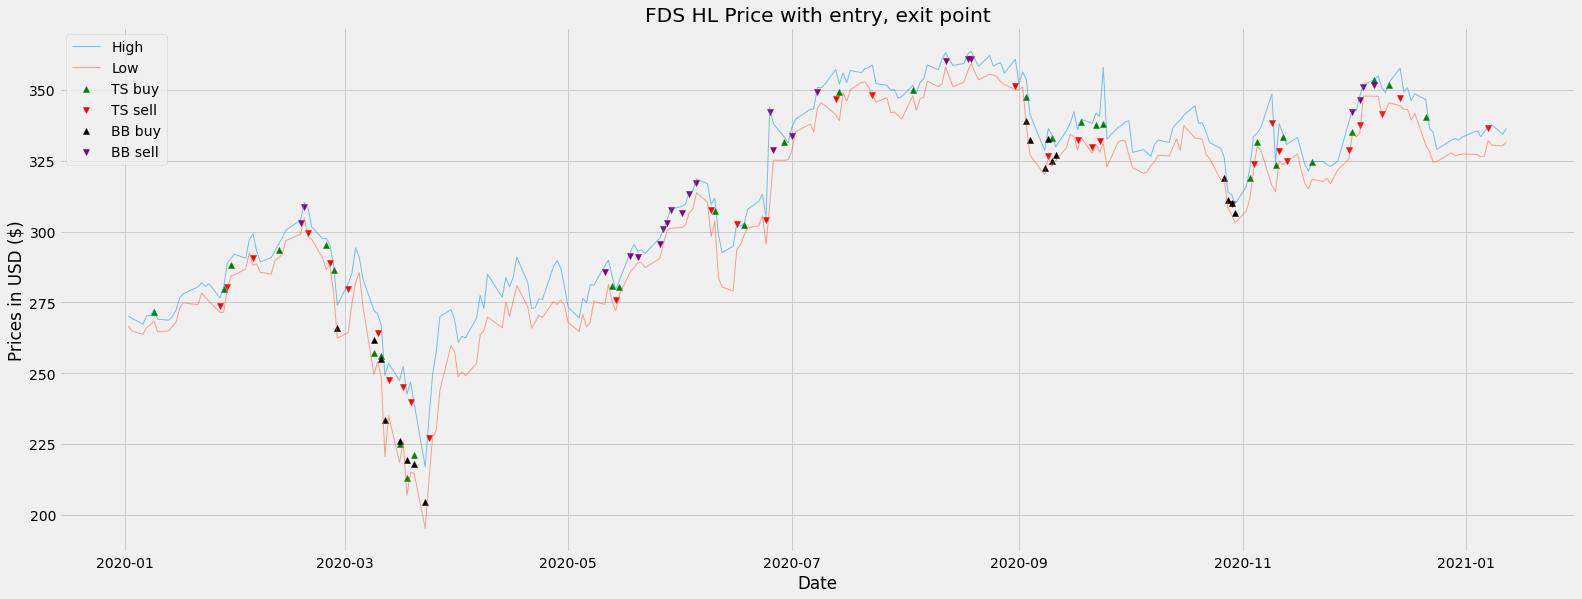

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(24.2,9))
plt.plot(df['High'], label = 'High', alpha = 0.5, linewidth = 1)
plt.plot(df['Low'], label = 'Low', alpha = 0.5, linewidth =1)
plt.scatter(df.index, df['TS_buy'], color = 'green', label = 'TS buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['TS_sell'], color = 'red', label = 'TS sell', marker = 'v', alpha = 1)
plt.scatter(df.index, df['b_buy'], color = 'black', label = 'BB buy', marker = '^', alpha = 1)
plt.scatter(df.index, df['b_sell'], color = 'purple', label = 'BB sell', marker = 'v', alpha = 1)
plt.title('FDS HL Price with entry, exit point')
plt.xlabel('Date')
plt.ylabel('Prices in USD ($)')
plt.legend(loc='upper left')
plt.show()

In [8]:
ddf = df.copy()
ddf = ddf.drop(['Open', 'Adj Close','SMA', 'Volume', '2xSTD', 'Tp_SMA', '2xTPSTD'], axis=1)

modulate buy, sell

In [16]:
def trailing_stop_signals_bb(df: pd.DataFrame(), b_up_ratio=1.03, step=0.01, c_down_ratio=1.03):
    buy_signal = [np.nan]; sell_signal = [np.nan]
    flag = 1 #  1 for buy, -1 for sell
    ceiling = 0 
    bottom = df['Low'][0]
    transactionDate = df.index
    bottom_up_ratio = b_up_ratio
    ceiling_down_ratio = c_down_ratio

    for i in range(len(df['High'])-1):
        if flag == 1:
            bottom = min(bottom, df['Low'][i+1])
            sell_signal.append(np.nan)
            if df['Low'][i+1] <= bottom*bottom_up_ratio < df['High'][i+1]: # limit order hit the next day
                buy_signal.append(bottom*bottom_up_ratio) 
                flag = -1
                ceiling = df['High'][i+1]
                ceiling_down_ratio = c_down_ratio
            elif ~np.isnan(df['b_buy'][i]):
                bottom_up_ratio = b_up_ratio + step
                buy_signal.append(np.nan)
            elif ~np.isnan(df['b_sell'][i]):
                bottom_up_ratio = b_up_ratio - step
                buy_signal.append(np.nan)
            else:
                buy_signal.append(np.nan)


    

0 1.02
1 1.03
2 2.01
